In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from CS2_bo_plotters import plot_obj_abs_min
from CS2_bo_plotters import path_name
from CS2_bo_functions import set_ep

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def csv_to_array(csv_path):
    """
    Turn a csv file into a numpy array so that it can be used with bo_plotters
    
    Parameters:
    -----------
        csv_path: str, path of csv you want to turn into an array
    Returns:
    --------
        csv_array: np.ndarray, array on values in the CSV file
    """
    
    csv_pd = pd.read_csv(csv_path, index_col = False)
    csv_pd.drop(columns=csv_pd.columns[0], 
        axis=1, 
        inplace=True)
    csv_array = csv_pd.to_numpy()
    
    return csv_array

In [4]:
emulator = False
obj = "obj"
sparse_grid = False
set_lengthscale = None
t = 20
fxn = "plot_obj_abs_min"
ep = set_ep(emulator, obj, sparse_grid)
tot_iter = 100
tot_runs =15
DateTime = "2022/10/10/13-19"
sep_fact = 1
is_figure = False
save_figure = False
# csv_end = "Min_SSE_Conv_Sep_Fact"

In [6]:
path = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, bo_iter= None, 
          title_save = None, run = None, tot_iter=tot_iter, tot_runs=tot_runs, DateTime = DateTime, 
                 sep_fact = sep_fact, is_figure = is_figure, csv_end = None)

In [7]:
print(path)
path = "2022/10/10/13-19/CSV_Data/Convergence_Figs/GP_Error_Emulator/TP_20/obj/ep_0.3/len_scl_varies/Sep_Fact_1.0/Total_Runs_15/Min_SSE_Conv.csv"
obj_abs_min = csv_to_array(path)

../2022/10/10/13-19/CSV_Data/Convergence_Figs/GP_Error_Emulator/TP_20/obj/ep_0.3/len_scl_varies/Sep_Fact_1.0/Total_Runs_15/Min_SSE_Conv


In [8]:
print(obj_abs_min)


[[2.81721367 2.60293997 2.55511315 ... 2.4007869  2.40052111 2.40026437]
 [2.81721393 2.60293992 2.55511357 ... 2.40118828 2.40092762 2.40066959]
 [2.81721379 2.60294003 2.55511268 ... 2.40144614 2.4011864  2.40092656]
 ...
 [2.81721376 2.60293985 2.55511283 ... 2.39859548 2.39834801 2.39809141]
 [2.81721374 2.60293991 2.55511319 ... 2.4003997  2.40013803 2.39988451]
 [2.81721372 2.60294008 2.54796017 ... 2.40019628 2.3999412  2.39967747]]


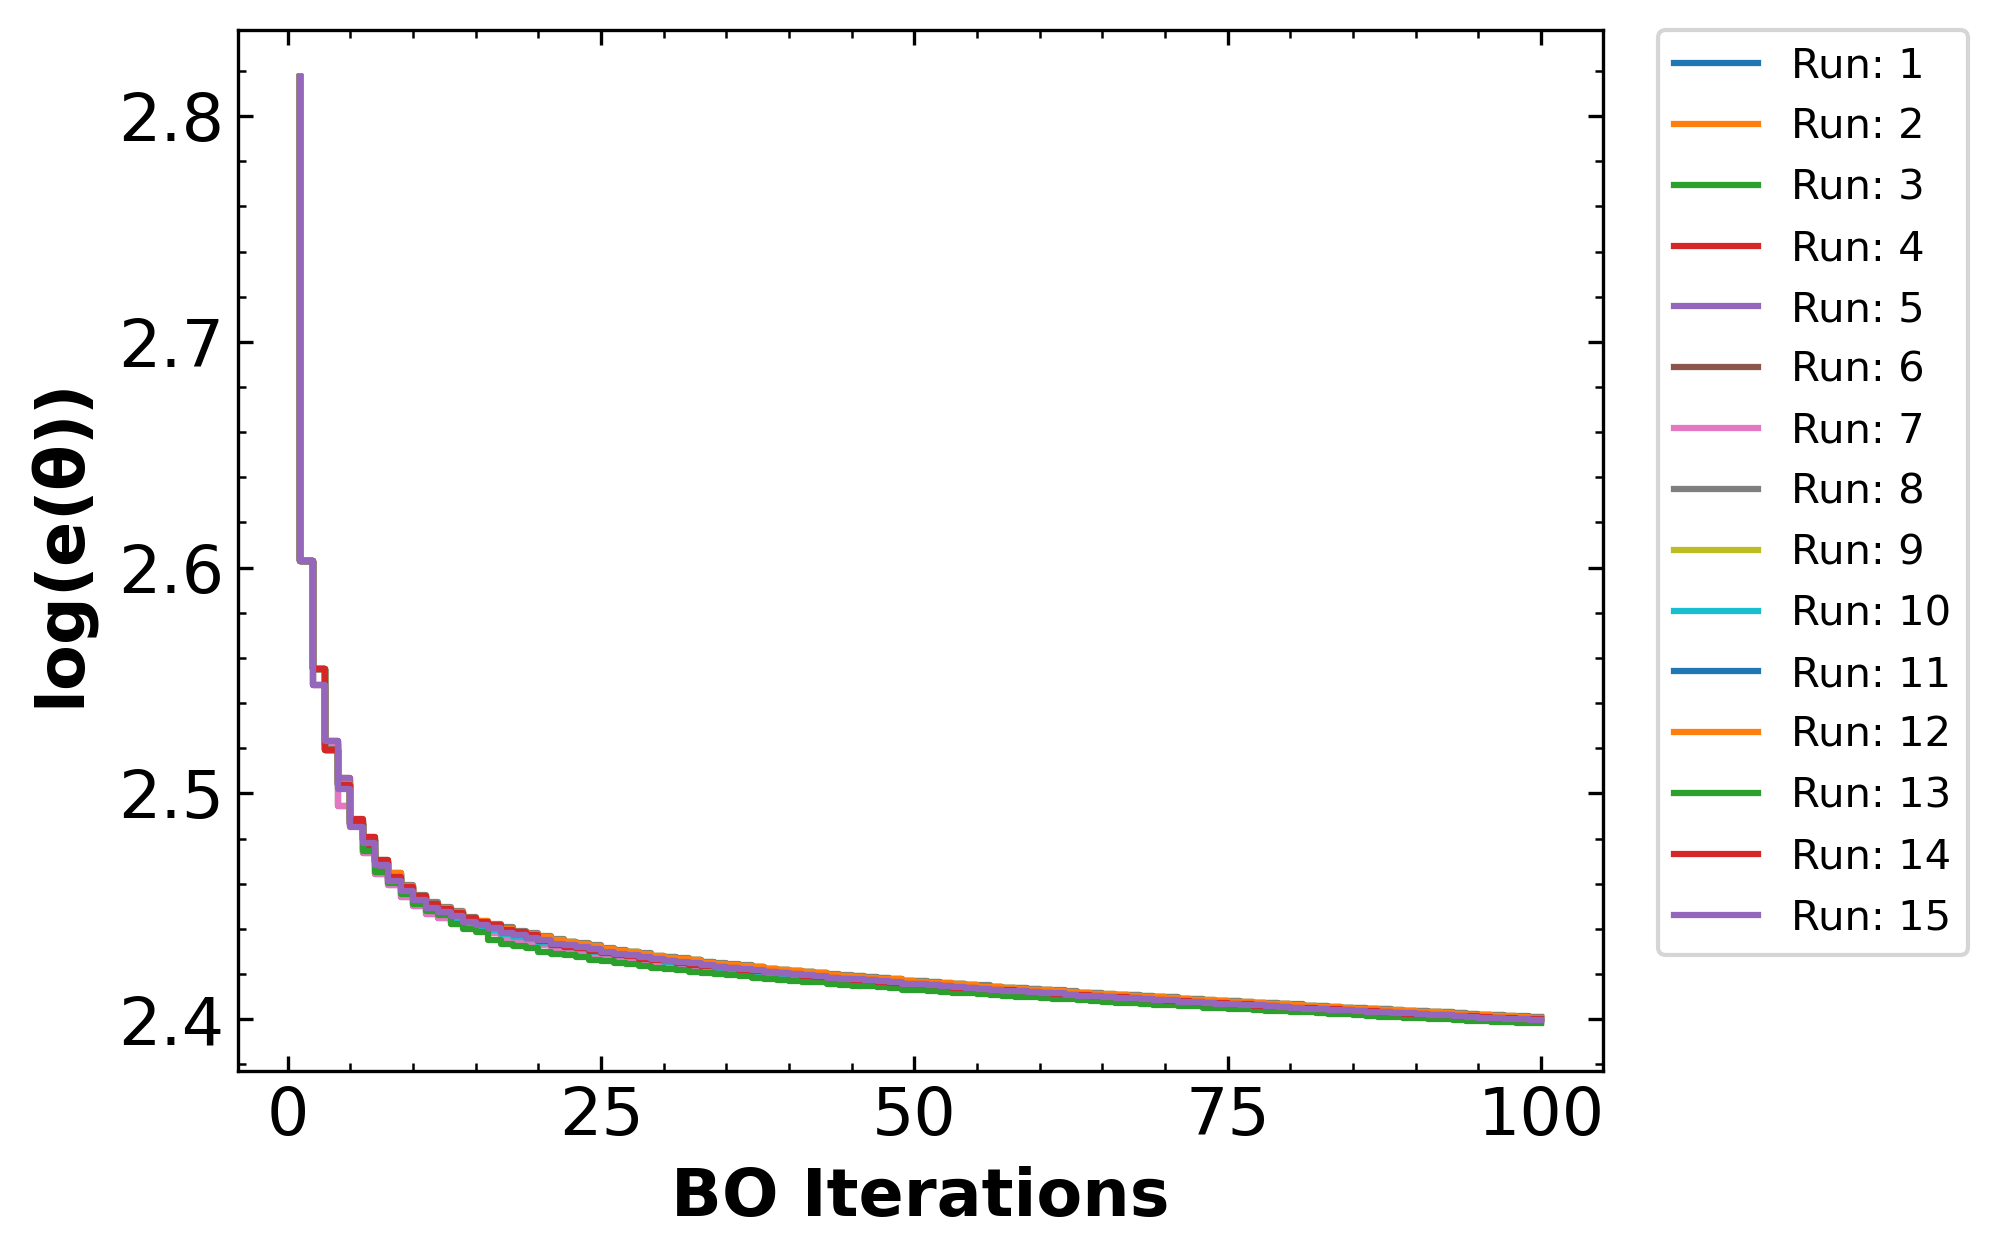

In [9]:
plot_obj_abs_min(obj_abs_min, emulator, ep, sparse_grid, set_lengthscale, t, obj, save_figure, tot_iter, tot_runs,DateTime, sep_fact)